In [5]:
# %load Assignment1_865_Q2_NeelanMuthurajah.py
# -*- coding: utf-8 -*-
"""
[Neelan, Muthurajah]
[20195484]
[MMA]
[Section 2]
[MMA 865]
[October 18th 2020]


Submission to Question [2], Part [1]
"""
# TODO: import other libraries as necessary

'\n[Neelan, Muthurajah]\n[20195484]\n[MMA]\n[Section 2]\n[MMA 865]\n[October 18th 2020]\n\n\nSubmission to Question [2], Part [1]\n'

## Import Libraries to Run Code Below

In [6]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import unidecode
import re
import textstat
from textblob import TextBlob
from nltk import word_tokenize
from nltk.util import ngrams
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score, classification_report, confusion_matrix, make_scorer, f1_score,accuracy_score, cohen_kappa_score, log_loss

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Import Data (Train and Test sets) 

In [7]:
#Import Train and Test Data
df_train = pd.read_csv("sentiment_train.csv")
df_test = pd.read_csv("sentiment_test.csv")

In [8]:
#Add column differentiating train and test data
df_train['Type']='Train'
df_test['Type']='Test'

#Append train and test data together for feature engineering & preprocessing 
df_complete = df_train.append(df_test)

#Drop any rows with NA's 
df_complete=df_complete.dropna()

## Data Exploration

In [9]:
#From a quick preview of the data, it is observed that positive sentiments are labeled as 1 whereas negative sentiments are labeled as 0
df_complete.head(10)

,Sentence,Polarity,Type
0,Wow... Loved this place.,1,Train
1,Crust is not good.,0,Train
2,Not tasty and the texture was just nasty.,0,Train
3,Stopped by during the late May bank holiday of...,1,Train
4,The selection on the menu was great and so wer...,1,Train
5,Now I am getting angry and I want my damn pho.,0,Train
6,Honeslty it didn't taste THAT fresh.),0,Train
7,The potatoes were like rubber and you could te...,0,Train
8,The fries were great too.,1,Train
9,A great touch.,1,Train


In [10]:
#Train set includes 2400 entries in total 
print(df_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  2400 non-null   object
 1   Polarity  2400 non-null   int64 
 2   Type      2400 non-null   object
dtypes: int64(1), object(2)
memory usage: 56.4+ KB
None


In [11]:
# Create dataframe showing count of positive sentences vs negative sentences in the training set 
train=df_train.groupby('Polarity')["Polarity"].count()
train=pd.DataFrame(train)
train

#Create dataset
Polarity_Train = ['Postive','Negative'] 
  
Count_Train = [1187,1213]

,Polarity
Polarity,
0,1213
1,1187


([<matplotlib.patches.Wedge at 0x1d9cdc83808>,
 [Text(0.0187177349766205, 1.099840736832995, 'Postive'),
  Text(-0.018717632002099378, -1.099840738585471, 'Negative')],
 [Text(0.01020967362361118, 0.5999131291816335, '49.46%'),
  Text(-0.010209617455690568, -0.5999131301375294, '50.54%')])

Text(0.5, 1.0, 'Training Data - 2400 Entries in Total')

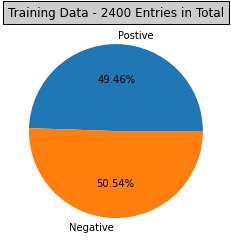

In [44]:
# Create pie chart showing split of positive sentences vs negative sentences in the training set
plt.pie(Count_Train,labels = Polarity_Train,radius=1,autopct='%0.2f%%')
plt.title("Training Data - 2400 Entries in Total", bbox={'facecolor':'0.8', 'pad':5})

# The plot shows that the data is not imbalanced. There is almost a 1:1 class balance of positive vs negative sentences
plt.show() 

In [13]:
#Test set includes 600 entries 
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  600 non-null    object
 1   Polarity  600 non-null    int64 
 2   Type      600 non-null    object
dtypes: int64(1), object(2)
memory usage: 14.2+ KB
None


In [14]:
# Create dataframe showing count of positive sentences vs negative sentences in the test set 
test=df_test.groupby('Polarity')["Polarity"].count()
test=pd.DataFrame(test)
test

#Create dataset
Polarity_Test = ['Postive','Negative'] 
  
Count_Test = [313,287]

,Polarity
Polarity,
0,287
1,313


([<matplotlib.patches.Wedge at 0x1d9cdccd208>,
 [Text(-0.07481674849112249, 1.0974527115758639, 'Postive'),
  Text(0.07481664574018342, -1.0974527185807086, 'Negative')],
 [Text(-0.04080913554061226, 0.5986105699504711, '52.17%'),
  Text(0.040809079494645496, -0.5986105737712956, '47.83%')])

Text(0.5, 1.0, 'Test Data - 600 Entries in Total')

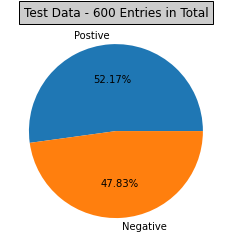

In [45]:
# Create plot showing split of positive sentences vs negative sentences in the testing set
plt.pie(Count_Test, labels = Polarity_Test,radius=1,autopct='%0.2f%%') 
plt.title("Test Data - 600 Entries in Total", bbox={'facecolor':'0.8', 'pad':5})

# The plot shows that the data is also not imbalanced in the test set. There is almost a 1:1 class balance of positive vs negative sentences
plt.show() 

## Text Preprocessing

In [16]:
#Create function in order to preprocess textual data by removing stop words, lowering letters, removing digits, lemmatizing
stop_words=set(stopwords.words('english')+stopwords.words('spanish'))
lemmer=WordNetLemmatizer()

def preprocess (x):
    x=x.lower()
    x=re.sub(r'[^\w\s\d+]','',x)
    x=unidecode.unidecode(x)
    x=[lemmer.lemmatize(w) for w in x.split() if w not in stop_words ]
    return ' '.join(x)

#Add a column for the sentence column after pre-processing 
df_complete['Sentence_Clean']=df_complete['Sentence'].apply(preprocess)

In [17]:
#Preview updated dataframe with the sentence clean column
df_complete.head()

,Sentence,Polarity,Type,Sentence_Clean
0,Wow... Loved this place.,1,Train,wow loved place
1,Crust is not good.,0,Train,crust good
2,Not tasty and the texture was just nasty.,0,Train,tasty texture nasty
3,Stopped by during the late May bank holiday of...,1,Train,stopped late may bank holiday rick steve recom...
4,The selection on the menu was great and so wer...,1,Train,selection menu great price


In [18]:
#Add other features to the dataset such as number of characters, syllable count, difficulty understanding passage
df_complete['len'] = df_complete['Sentence_Clean'].apply(lambda x:len(x))
df_complete['syllable_count'] = df_complete['Sentence_Clean'].apply(lambda x: textstat.syllable_count(x))

#A metric to indicate how difficult a passage is to understand
df_complete['flesch_reading_case'] = df_complete['Sentence_Clean'].apply(lambda x: textstat.flesch_reading_ease(x))

In [19]:
#Preview the updated dataframe with these added features (length, syllable count, difficulty understanding passage)
df_complete.head()

,Sentence,Polarity,Type,Sentence_Clean,len,syllable_count,flesch_reading_case
0,Wow... Loved this place.,1,Train,wow loved place,15,3,119.19
1,Crust is not good.,0,Train,crust good,10,2,120.21
2,Not tasty and the texture was just nasty.,0,Train,tasty texture nasty,19,4,93.81
3,Stopped by during the late May bank holiday of...,1,Train,stopped late may bank holiday rick steve recom...,61,15,53.88
4,The selection on the menu was great and so wer...,1,Train,selection menu great price,26,6,75.88


In [20]:
#Convert 'sentence clean' column to a string datatype 
df_complete['Sentence_Clean'] = df_complete['Sentence_Clean'].astype(str)

In [21]:
#Run each review through textblob to determine overall sentiment
sentiment = []
sentiment2 = []

#Take textblob score and classify sentences into positive or negative based on a threshold
for sentence in df_complete['Sentence_Clean'] :
    sent = TextBlob(sentence)
    if sent.sentiment.polarity > 0.0:
        sentiment.append(1)
    else:
        sentiment.append(0)

#Take textblob score as is and add it to the final dataframe for modeling 
for sentence2 in df_complete['Sentence_Clean'] :
    sent = TextBlob(sentence2)
    if sent.sentiment.polarity > 0.0:
        sentiment2.append(sent.sentiment.polarity)
    else:
        sentiment2.append(sent.sentiment.polarity)
    
# Create 2 columns from the sentiment analysis above. If score was above 0, positive sentiment otherwise 0 for negative sentiment
df_complete['sentiment'] = sentiment
df_complete['sentiment_score'] = sentiment2

In [22]:
#Preview dataframe  
df_complete.head(20)

,Sentence,Polarity,Type,Sentence_Clean,len,syllable_count,flesch_reading_case,sentiment,sentiment_score
0,Wow... Loved this place.,1,Train,wow loved place,15,3,119.19,1,0.40000
1,Crust is not good.,0,Train,crust good,10,2,120.21,1,0.70000
2,Not tasty and the texture was just nasty.,0,Train,tasty texture nasty,19,4,93.81,0,-1.00000
3,Stopped by during the late May bank holiday of...,1,Train,stopped late may bank holiday rick steve recom...,61,15,53.88,1,0.20000
4,The selection on the menu was great and so wer...,1,Train,selection menu great price,26,6,75.88,1,0.80000
5,Now I am getting angry and I want my damn pho.,0,Train,getting angry want damn pho,27,7,83.32,0,-0.50000
6,Honeslty it didn't taste THAT fresh.),0,Train,honeslty didnt taste fresh,26,5,92.80,1,0.30000
7,The potatoes were like rubber and you could te...,0,Train,potato like rubber could tell made ahead time ...,57,12,95.17,0,0.00000
8,The fries were great too.,1,Train,fry great,9,2,120.21,1,0.80000
9,A great touch.,1,Train,great touch,11,2,120.21,1,0.80000


In [23]:
#Split data back into train and test after pre-processing 
df_train=df_complete[(df_complete.Type=='Train')]
df_test=df_complete[(df_complete.Type=='Test')]

In [24]:
#Create BOW using TF-IDF 
#max_df=if a word is in 99.5% or more of the documents remove it
#min_df=if a word in in fewer than 0.5% of the documents remove it 
#max features= only keep 2000 most frequent words 
#ngrams of 1 to 2 consider 1 grams & 2 grams 

vectorizer = TfidfVectorizer(max_df=0.995, min_df=0.005, 
                             max_features=2000, ngram_range=[1,2])

dtm_train = vectorizer.fit_transform(df_train['Sentence_Clean'])
print(dtm_train.shape)

dtm_test=vectorizer.transform(df_test['Sentence_Clean'])
print(dtm_test.shape)

(2400, 221)
(600, 221)


In [25]:
#Show list of words from the BOW using TF-IDF
vectorizer.get_feature_names()

['10',
 'absolutely',
 'also',
 'always',
 'amazing',
 'another',
 'anyone',
 'around',
 'away',
 'awesome',
 'back',
 'bad',
 'bar',
 'battery',
 'beautiful',
 'best',
 'better',
 'big',
 'bit',
 'bland',
 'bluetooth',
 'bought',
 'buffet',
 'burger',
 'buy',
 'call',
 'came',
 'camera',
 'cant',
 'car',
 'case',
 'cell',
 'character',
 'charge',
 'charger',
 'cheap',
 'chicken',
 'clear',
 'come',
 'comfortable',
 'cool',
 'could',
 'couldnt',
 'customer',
 'customer service',
 'day',
 'definitely',
 'delicious',
 'design',
 'device',
 'didnt',
 'disappointed',
 'dish',
 'doesnt',
 'dont',
 'ear',
 'easy',
 'eat',
 'enough',
 'even',
 'ever',
 'every',
 'everything',
 'excellent',
 'experience',
 'extremely',
 'family',
 'fantastic',
 'far',
 'feel',
 'felt',
 'film',
 'find',
 'fine',
 'first',
 'fit',
 'flavor',
 'food',
 'found',
 'fresh',
 'friendly',
 'funny',
 'get',
 'give',
 'go',
 'go back',
 'going',
 'good',
 'got',
 'great',
 'happy',
 'hard',
 'headset',
 'hear',
 'highl

In [26]:
#Append BOW to train set 
bow_df_train = pd.DataFrame(dtm_train.toarray(),columns=vectorizer.get_feature_names(),index=df_train.index)
df_train = pd.concat([df_train,bow_df_train],axis=1)
df_train.head()

,Sentence,Polarity,Type,Sentence_Clean,len,syllable_count,flesch_reading_case,sentiment,sentiment_score,10,...,wont,work,work great,worked,working,worst,worth,would,would recommend,year
0,Wow... Loved this place.,1,Train,wow loved place,15,3,119.19,1,0.4,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Crust is not good.,0,Train,crust good,10,2,120.21,1,0.7,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Not tasty and the texture was just nasty.,0,Train,tasty texture nasty,19,4,93.81,0,-1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Stopped by during the late May bank holiday of...,1,Train,stopped late may bank holiday rick steve recom...,61,15,53.88,1,0.2,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,The selection on the menu was great and so wer...,1,Train,selection menu great price,26,6,75.88,1,0.8,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
#Append BOW to test set
bow_df_test = pd.DataFrame(dtm_test.toarray(),columns=vectorizer.get_feature_names(),index=df_test.index)
df_test = pd.concat([df_test,bow_df_test],axis=1)
df_test.head()

,Sentence,Polarity,Type,Sentence_Clean,len,syllable_count,flesch_reading_case,sentiment,sentiment_score,10,...,wont,work,work great,worked,working,worst,worth,would,would recommend,year
0,A good commentary of today's love and undoubte...,1,Test,good commentary today love undoubtedly film wo...,56,15,37.98,1,0.500000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.60155,0.0,0.0,0.0
1,For people who are first timers in film making...,1,Test,people first timer film making think excellent...,50,12,71.82,1,0.625000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0
2,"It was very popular when I was in the cinema, ...",1,Test,popular cinema good house good reaction plenty...,52,15,37.98,1,0.575000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0
3,It's a feel-good film and that's how I felt wh...,1,Test,feelgood film thats felt came cinema,36,10,56.93,0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0
4,It has northern humour and positive about the ...,1,Test,northern humour positive community represents,45,14,-35.13,1,0.227273,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0


In [28]:
#Append predicted polarity to a new dataframe for the test data (this new dataframe will be used to answer Question 2 Part 3)
df_test2 = pd.read_csv("sentiment_test.csv")
df_test2['Sentence Clean'] = df_test['Sentence_Clean'].values
df_test2['Predicted Polarity from Textblob'] = df_test['sentiment'].values
df_test2['Predicted Polarity Score from Textblob'] = df_test['sentiment_score'].values

In [29]:
#Drop sentence, type and sentence clean columns as they are no longer needed since BOW, text preprocessing on sentiment was done in the pre processing steps above
df_train=df_train.drop(['Sentence','Type','Sentence_Clean'], axis=1)
df_test=df_test.drop(['Sentence','Type','Sentence_Clean'], axis=1)

## Model Development (Random Forest)

In [30]:
#Split data into train and test sets 
X = df_train.drop('Polarity', axis=1)
y = df_train['Polarity']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
type(X_train)
X_train.shape
X_train.head()

type(y_train)
y_train.shape
y_train.head()

pandas.core.frame.DataFrame

(1920, 226)

,len,syllable_count,flesch_reading_case,sentiment,sentiment_score,10,absolutely,also,always,amazing,...,wont,work,work great,worked,working,worst,worth,would,would recommend,year
120,80,21,42.38,0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
283,38,10,32.56,0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1727,47,9,113.10,1,0.324286,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1984,39,8,66.40,0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
647,17,5,59.97,1,0.425000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


pandas.core.series.Series

(1920,)

120     0
283     0
1727    1
1984    0
647     0
Name: Polarity, dtype: int64

In [32]:
#Grid Search with cross validation

#Score_func defines the performance measure (in this case auc) which the gridsearchCV should evaluate the models on 
score_func = make_scorer(roc_auc_score, greater_is_better=True)

# Create a parameter grid to test various hyper parameter values for the random forest model 
param_grid_rf = {
    'max_depth': [130, 150, 180],
    'max_features': [10, 15, 20],
    'min_samples_leaf': [5, 10, 15],
    'min_samples_split': [10, 20, 30],
    'n_estimators': [500, 1000, 1500]
}

# Defining the Random Forest Classifier model
classifier_RF = RandomForestClassifier(random_state=42)

# Initiate RF model using a variety of hyperparameters from the parameter grid above as well as a 5-fold cross validation
grid_search_rf = GridSearchCV(estimator = classifier_RF, param_grid = param_grid_rf, 
                          cv = 5, scoring = score_func, n_jobs=-1,return_train_score = True, verbose = 2)

In [33]:
#Apply model above on just the training data 
grid_search_RF = grid_search_rf.fit(X_train, y_train)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 1215 out of 1215 | elapsed: 10.2min finished


In [34]:
#Output the best hyper parameter values where auc for the model was the highest
print('\nBest Hyper-Parameter values Random Forest:'+str(grid_search_RF.best_params_))
grid_search_RF.best_params_

#Best Estimator for Random Forest Model
best_grid_rf = grid_search_RF.best_estimator_

#Score of the best model
best_result_rf = grid_search_RF.best_score_
print("\nBest Score Random Forest: " + str(best_result_rf))


Best Hyper-Parameter values Random Forest:{'max_depth': 130, 'max_features': 20, 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 1000}


{'max_depth': 130,
 'max_features': 20,
 'min_samples_leaf': 5,
 'min_samples_split': 20,
 'n_estimators': 1000}


Best Score Random Forest: 0.7771790283165595


In [35]:
#Using the above (best) model with the best hyper parameter values to predict on the testing data
class_threshold = 0.50
y_pred_prob_rf = grid_search_RF.predict_proba(X_val)[:,1]
y_pred_rf = np.where(y_pred_prob_rf > class_threshold, 1, 0) # classification

In [36]:
#Display confusion matrix, classification report and F1 score from Sklearn package 
print("Confusion matrix:")
print(confusion_matrix(y_val, y_pred_rf))

print("\nF1 Score = {:.5f}".format(f1_score(y_val, y_pred_rf, average="micro")))

print("\nClassification Report:")
print(classification_report(y_val, y_pred_rf))

Confusion matrix:
[[208  49]
 [ 47 176]]

F1 Score = 0.80000

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.81      0.81       257
           1       0.78      0.79      0.79       223

    accuracy                           0.80       480
   macro avg       0.80      0.80      0.80       480
weighted avg       0.80      0.80      0.80       480



<Figure size 1080x360 with 0 Axes>

Text(0.5, 1.0, 'Feature Importance Random Forest')

Text(0.5, 0, 'Decrease in Gini')

<AxesSubplot:title={'center':'Feature Importance Random Forest'}, xlabel='Decrease in Gini'>

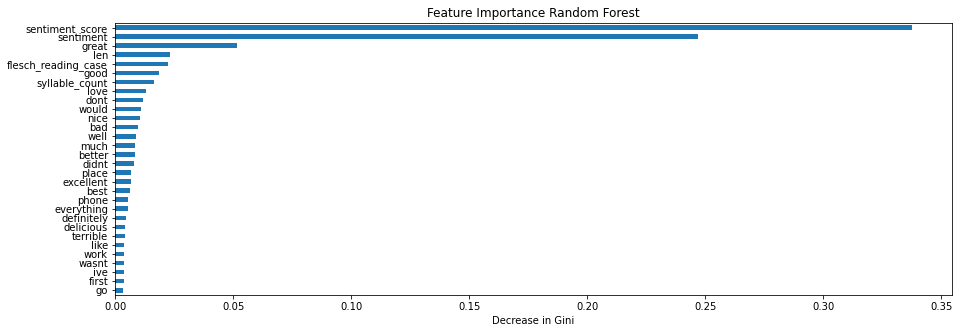

In [37]:
#Feature Importance - Using Random Forest Model
importances = grid_search_RF.best_estimator_.feature_importances_ 

#Plot the variables according to their importance
plt.figure(figsize=(15,5))
plt.title('Feature Importance Random Forest')
plt.xlabel('Decrease in Gini')
feature_importances = pd.Series(grid_search_RF.best_estimator_.feature_importances_ , index=X_train.columns)
feature_importances.nlargest(30).sort_values().plot(kind='barh', align='center')

## Make Prediction on Validation Set 

In [38]:
X = df_test.drop('Polarity', axis=1)
y = df_test['Polarity']

y_pred_prob_rf_val = grid_search_RF.predict_proba(X)[:,1]
y_pred_rf_val = np.where(y_pred_prob_rf_val > class_threshold, 1, 0) 


#Validate performance of random forest model on the provided test data (600 records in total)
print("Confusion matrix:")
print(confusion_matrix(y, y_pred_rf_val))

print("\nF1 Score = {:.5f}".format(f1_score(y, y_pred_rf_val, average="micro")))

print("\nClassification Report:")
print(classification_report(y, y_pred_rf_val))

Confusion matrix:
[[241  46]
 [ 87 226]]

F1 Score = 0.77833

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.84      0.78       287
           1       0.83      0.72      0.77       313

    accuracy                           0.78       600
   macro avg       0.78      0.78      0.78       600
weighted avg       0.78      0.78      0.78       600



In [39]:
#Append predicted polarity to original test data
df_test2['Predicted Polarity from RF Model'] = pd.Series(y_pred_rf_val, index=df_test.index)

conditions = [
    (df_test2['Polarity'] == 1) & (df_test2['Predicted Polarity from RF Model'] == 1),
    (df_test2['Polarity'] == 1) & (df_test2['Predicted Polarity from RF Model'] == 0),
    (df_test2['Polarity'] == 0) & (df_test2['Predicted Polarity from RF Model'] == 0),
    (df_test2['Polarity'] == 0) & (df_test2['Predicted Polarity from RF Model'] == 1),
    ]

# create a list of the values we want to assign for each condition
values = ['TP', 'FN', 'TN', 'FP']

# create a new column and use np.select to assign values to it using our lists as arguments
df_test2['Condition'] = np.select(conditions, values)

df_FN=df_test2[(df_test2.Condition=='FN')]
df_FP=df_test2[(df_test2.Condition=='FP')]

In [40]:
#Preview the two dataframes. One for FP's and one for FN's. 
df_FP.head(20)
df_FN.head(20)

#Export files for Question 2 Part 3
df_FP.to_csv ('FP.csv', index = False, header=True)
df_FN.to_csv ('FN.csv', index = False, header=True)

,Sentence,Polarity,Sentence Clean,Predicted Polarity from Textblob,Predicted Polarity Score from Textblob,Predicted Polarity from RF Model,Condition
33,It came free with a DVD player I bought but I ...,0,came free dvd player bought still turned thing...,1,0.400000,1,FP
39,"Yes, I am simplifying things here for the sake...",0,yes simplifying thing sake brevity really core...,1,0.200000,1,FP
53,Not even good for camp value!,0,even good camp value,1,0.700000,1,FP
62,Considering the relations off screen between T...,0,considering relation screen taylor stanwyck su...,1,0.256250,1,FP
77,The directing is sloppy at best.,0,directing sloppy best,1,0.291667,1,FP
80,The acting by the whole cast could be put on a...,0,acting whole cast could put scale balanced per...,1,0.400000,1,FP
81,"And, FINALLY, after all that, we get to an end...",0,finally get ending wouldve great handled compe...,1,0.433333,1,FP
108,What this film lacks is a convincing script.,0,film lack convincing script,1,0.500000,1,FP
110,"Things happen, characters personalities change...",0,thing happen character personality change plot...,1,0.200000,1,FP
124,Full of unconvincing cardboard characters it i...,0,full unconvincing cardboard character blandly ...,1,0.420833,1,FP


,Sentence,Polarity,Sentence Clean,Predicted Polarity from Textblob,Predicted Polarity Score from Textblob,Predicted Polarity from RF Model,Condition
3,It's a feel-good film and that's how I felt wh...,1,feelgood film thats felt came cinema,0,0.000000,0,FN
14,I would have casted her in that role after rea...,1,would casted role ready script,1,0.200000,0,FN
36,"The soundtrack wasn't terrible, either.",1,soundtrack wasnt terrible either,0,-1.000000,0,FN
38,"Still, it was the SETS that got a big ""10"" on ...",1,still set got big 10 oyvey scale,0,0.000000,0,FN
43,The last 15 minutes of movie are also not bad ...,1,last 15 minute movie also bad well,0,-0.350000,0,FN
86,Overall I rate this movie a 10 out of a 1-10 s...,1,overall rate movie 10 110 scale,0,0.000000,0,FN
87,"Lifetime does not air it enough, so if anyone ...",1,lifetime air enough anyone know store sell let...,0,0.000000,0,FN
90,"Totally different, with loads of understatemen...",1,totally different load understatement black co...,0,-0.083333,0,FN
93,See it.,1,see,0,0.000000,0,FN
94,I really hope the team behind this movie makes...,1,really hope team behind movie make movie conti...,0,-0.233333,0,FN
